In [106]:
import tensorflow as tf
import pickle
import glob
import PIL
import numpy as np
import pandas as pd
import keract
import matplotlib.pyplot as plt
from keras_visualizer import visualizer 
from keract import get_activations
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications.vgg16 import VGG16
print(tf.__version__)
#np.random.seed(1)

2.6.0


Load images from folders

In [ ]:
#generate multiple data
# aug = ImageDataGenerator(rotation_range=45,zoom_range=0.15,width_shift_range=0.25,
#                          height_shift_range=0.3,shear_range=0.1,horizontal_flip=True,fill_mode="nearest")


# for file in glob.glob('covers/**/*.png', recursive=True):
#     img_arr = img_to_array(PIL.Image.open(file).resize((224,224)))
#     label = (file.split('/')[1] + "-" +  file.split('/')[2])
#     if len(img_arr.shape) == 3:
#         img_arr = img_arr.reshape((1,) + img_arr.shape)
#         i = 0
#         for batch in aug.flow(img_arr, batch_size=1,
#                           save_to_dir='covers/' + file.split('/')[1] + '/' + file.split('/')[2] , save_prefix=label, save_format='png'):
#             i += 1
#             if i > 10:
#                 break 
        


Index(['Taco Hemingway-Cafe Belga', 'Taco Hemingway-Europa',
       'Taco Hemingway-Jarmark', 'Taco Hemingway-Pocztówka z WWA',
       'Taco Hemingway-Szprycer', 'Taco Hemingway-Wosk'],
      dtype='object')


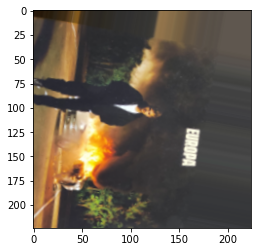

In [107]:
train_images = []
train_labels  = []
train_labels_human = []
for file in glob.glob('covers/**/*.png', recursive=True):
    img_arr = np.asarray(PIL.Image.open(file).convert('RGB').resize((224,224)))
    label = (file.split('/')[1] + "-" +  file.split('/')[2])
    if len(img_arr.shape) == 3:
        train_images.append(img_arr)
        train_labels.append(label)

dumm = pd.get_dummies(train_labels)
train_labels = dumm.values
train_labels_human = dumm.columns
train_images = np.array(train_images)

train_labels[0]
x_train,x_test,y_train,y_test = train_test_split(train_images,train_labels, test_size=0.3)
plt.imshow(x_train[10])
print(train_labels_human)


Prepare model

In [109]:
x,y,c = x_train[0].shape


model = Sequential()
model.add(layers.Rescaling(scale=1./255,input_shape=(224,224,3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(layers.Flatten())

model.add(layers.Dense(units=128,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=64,activation="relu"))
model.add(layers.Dense(units=32,activation="relu"))
model.add(layers.Dense(units=len(y_train[0]), activation="softmax"))

model.build()
model.summary()

model.compile(loss='categorical_crossentropy'
              , metrics=['acc'], optimizer='rmsprop')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 32)       

Model train

In [115]:
history = model.fit(x_train,y_train,epochs=20,batch_size=100,validation_data=(x_test,y_test))

Epoch 1/20
24/24 [==============================] - 27s 1s/step - loss: 0.2354 - acc: 0.9312 - val_loss: 2.0957 - val_acc: 0.5117
Epoch 2/20
24/24 [==============================] - 26s 1s/step - loss: 0.2922 - acc: 0.9124 - val_loss: 0.3602 - val_acc: 0.8716
Epoch 3/20
24/24 [==============================] - 26s 1s/step - loss: 0.3192 - acc: 0.8982 - val_loss: 0.5041 - val_acc: 0.8181
Epoch 4/20
24/24 [==============================] - 26s 1s/step - loss: 0.2502 - acc: 0.9237 - val_loss: 0.3399 - val_acc: 0.8842
Epoch 5/20
24/24 [==============================] - 27s 1s/step - loss: 0.1706 - acc: 0.9479 - val_loss: 0.5241 - val_acc: 0.8074
Epoch 6/20
24/24 [==============================] - 27s 1s/step - loss: 0.1376 - acc: 0.9579 - val_loss: 0.2857 - val_acc: 0.9066
Epoch 7/20
24/24 [==============================] - 26s 1s/step - loss: 0.2143 - acc: 0.9328 - val_loss: 0.1239 - val_acc: 0.9543
Epoch 8/20
24/24 [==============================] - 27s 1s/step - loss: 0.1533 - acc: 0.95

This image most likely belongs to Taco Hemingway-Europa with a 35.22 percent confidence.


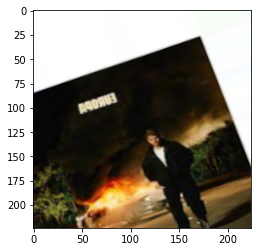

In [118]:
img_array = x_test[211]
plt.imshow(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_labels_human[np.argmax(score)], 100 * np.max(score))
)


In [121]:
model.save('model.h5')
outfile = open('labels.pcl','wb')
pickle.dump(train_labels_human,outfile)
outfile.close()

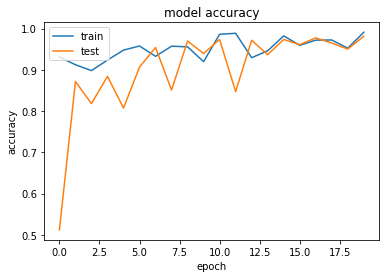

In [119]:


# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


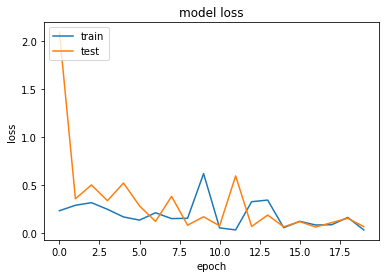

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()